## Librerias que utilizo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
%matplotlib inline

## Importacion de la data y validaciones iniciales

In [2]:
titanic = pd.read_csv("titanic_MD.csv")
titanicG = pd.read_csv("titanic.csv")

print('Titanic Malo shape:', titanic.shape)
print('Titanic Bueno shape:', titanicG.shape)

Titanic Malo shape: (183, 12)
Titanic Bueno shape: (183, 12)


In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",?,38.0,1.0,0.0,PC 17599,71.2833,C85,C
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,NaN,1.0,NaN,PP 9549,16.7000,G6,S
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,NaN,0.0,113783,26.5500,C103,S


In [4]:
titanicG.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,158.000000,180.000000,171.000000,175.000000
mean,455.366120,0.672131,1.191257,35.692532,0.461111,0.461988,78.959191
std,247.052476,0.470725,0.515187,15.640858,0.646122,0.753435,77.026328
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,35.500000,0.000000,0.000000,56.929200
75%,676.000000,1.000000,1.000000,48.000000,1.000000,1.000000,90.539600
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


## 1. Datos faltantes por columna

#### Buscando NAs

In [6]:
titanic.isna().sum()

PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age            25
SibSp           3
Parch          12
Ticket          0
Fare            8
Cabin           0
Embarked       12
dtype: int64

#### Buscando valores extraños en valores String. De todos, solo Sex mostró valores diferentes fáciles de detectar

In [7]:
cols = []
val = []
for col in titanic.select_dtypes(include='object').columns:
    cols.append(col)
    val.append(titanic[col].str.contains(r'\?').sum())
pd.DataFrame({
    'cols':cols,
    'val':val
})

,cols,val
0,Name,0
1,Sex,51
2,Ticket,0
3,Cabin,0
4,Embarked,0


#### Buscando valores anormales en la data numérica. Age y Fare contienen valores extraños ya que Age no puede tener decimales y Fare no puede tener 0s

In [8]:
np.unique(titanic['Age'])

array([ 0.92,  2.  ,  3.  ,  4.  ,  6.  , 11.  , 14.  , 15.  , 16.  ,
       17.  , 18.  , 19.  , 21.  , 22.  , 23.  , 24.  , 25.  , 27.  ,
       28.  , 29.  , 30.  , 31.  , 32.  , 33.  , 34.  , 35.  , 36.  ,
       36.5 , 37.  , 38.  , 39.  , 40.  , 41.  , 42.  , 43.  , 44.  ,
       45.  , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  ,
       54.  , 55.  , 56.  , 58.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 70.  , 71.  , 80.  ,   nan])

In [9]:
titanic["Fare"].quantile([.00, .10, .25, .50, .75, .90, 1.00])

0.00      0.00000
0.10     13.31668
0.25     29.70000
0.50     56.92920
0.75     90.53960
0.90    153.46250
1.00    512.32920
Name: Fare, dtype: float64

### Survived, Pclass están bien. Sex, Age, SibSp, Parch, Fare y Embarked tienen datos faltantes detallados previamente.
### Se excluyeron de la exploración NAME, CABIN, PASSENGERID y TICKET, ya que estas cuatro columnas describen a una sola persona, no a un conjunto, por lo que a la hora de predecir si puede sobrevivir o no, estas columnas muy específicas no nos servirían

## 2. Tipo de limpieza de datos por columna

-Sex (texto): usaré la Moda Sectorizada porque puedo sectorizar por valores que ya tengo para sacar cuál es el sexo que más se repite por sector y asumir que esos faltantes lo son, ya que 51 observaciones si afecta.

-Age (número): usaré la Media porque el promedio de todos a bordo puede abarcar mejor el rango normal, aunque los valores extremos pueden fallar, los valores centrales de la distribución pueden estar muy cerca de la imputación.

-SibSp (número): usaré la Moda porque son solo 3 datos faltantes y partiré por el supuesto de que esas 3 personas estaban casadas y tenian el mismo número de hijos por temas culturales de la época.

-Parch (número): usaré la Media aproximada ya que son 12 datos, no afectará mucho y son solo valores enteros. Además, voy a partir del supuesto de que esas 12 personas tienen el promedio de familiares extra a bordo pero aproximado al valor más cercano.

-Fare (número): usaré una Regresión Lineal ya que puedo usar la clase y valores faltantes calculados (como acompañantes) para predecir el posible valor de su ticket.

-Embarked (texto): usaré la Moda porque son pocos datos faltantes (no influye mucho en el modelo) y partiré por el supuesto de que esas 12 personas abordaron en el mismo puerto.

## 3. Cantidad de filas completas

In [10]:
titanic.replace(r'\?', np.nan, regex = True, inplace = True)
titanic.dropna().shape

(100, 12)

In [11]:
# % por cada columna
nas = pd.DataFrame(titanic.isna().sum()/titanic.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,PassengerId,0.000000
1,Survived,0.000000
2,Pclass,0.000000
3,Name,0.000000
4,Sex,0.278689
5,Age,0.136612
6,SibSp,0.016393
7,Parch,0.065574
8,Ticket,0.000000
9,Fare,0.043716


#### Hay 100 filas completas en la tabla, tomando las consideraciones descritas arriba

## 4. Eliminación de NAs

#### Imputacion por media, mediana y moda

In [12]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [13]:
#Sex
comparativa = pd.DataFrame(imp_mode.fit_transform(titanic[['Sex']]), columns = ['Sex_mode'])

In [14]:
#Age
#Media
comparativa['Age_mean'] = imp_mean.fit_transform(titanic[['Age']])
comparativa['Age_mean'] = round(comparativa['Age_mean'], 2)

#Mediana
comparativa['Age_median'] = imp_median.fit_transform(titanic[['Age']])

#Moda
comparativa['Age_mode'] = imp_mode.fit_transform(titanic[['Age']])

In [15]:
#SibSp
#Media
comparativa['SibSp_mean'] = imp_mean.fit_transform(titanic[['SibSp']])
comparativa['SibSp_mean'] = round(comparativa['SibSp_mean'])

#Mediana
comparativa['SibSp_median'] = imp_median.fit_transform(titanic[['SibSp']])
comparativa['SibSp_median'] = round(comparativa['SibSp_median'])

#Moda
comparativa['SibSp_mode'] = imp_mode.fit_transform(titanic[['SibSp']])
comparativa['SibSp_mode'] = round(comparativa['SibSp_mode'])

In [16]:
#Parch
#Media
comparativa['Parch_mean'] = imp_mean.fit_transform(titanic[['Parch']])
comparativa['Parch_mean'] = round(comparativa['Parch_mean'])

#Mediana
comparativa['Parch_median'] = imp_median.fit_transform(titanic[['Parch']])
comparativa['Parch_median'] = round(comparativa['Parch_median'])

#Moda
comparativa['Parch_mode'] = imp_mode.fit_transform(titanic[['Parch']])
comparativa['Parch_mode'] = round(comparativa['Parch_mode'])

In [17]:
#Fare
#Media
comparativa['Fare_mean'] = imp_mean.fit_transform(titanic[['Fare']])
comparativa['Fare_mean'] = round(comparativa['Fare_mean'], 2)

#Mediana
comparativa['Fare_median'] = imp_median.fit_transform(titanic[['Fare']])

#Moda
comparativa['Fare_mode'] = imp_mode.fit_transform(titanic[['Fare']])

In [18]:
#Embarked
comparativa['Embarked_mode'] = imp_mode.fit_transform(titanic[['Embarked']])
comparativa

,Sex_mode,Age_mean,Age_median,Age_mode,SibSp_mean,SibSp_median,SibSp_mode,Parch_mean,Parch_median,Parch_mode,Fare_mean,Fare_median,Fare_mode,Embarked_mode
0,male,38.00,38.0,38.0,1.0,1.0,1.0,0.0,0.0,0.0,71.28,71.2833,71.2833,C
1,female,35.00,35.0,35.0,1.0,1.0,1.0,0.0,0.0,0.0,53.10,53.1000,53.1000,S
2,male,54.00,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,51.86,51.8625,51.8625,S
3,female,35.69,35.5,24.0,1.0,1.0,1.0,0.0,0.0,0.0,16.70,16.7000,16.7000,S
4,female,58.00,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,26.55,26.5500,26.5500,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,female,47.00,47.0,47.0,1.0,1.0,1.0,1.0,1.0,1.0,78.96,56.9292,26.5500,S
179,male,35.69,35.5,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.0000,5.0000,S
180,female,56.00,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,83.16,83.1583,83.1583,S
181,male,19.00,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,30.0000,30.0000,S


#### Regresión Lineal

In [19]:
titanic_clean = titanic.dropna()
titanic_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,D56,S
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,B30,C
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,C83,S


In [20]:
def regre(x,y): 
    lm = LinearRegression()
    lm.fit(x,y)
    y_hat = lm.predict(x)
    error = (1/2*np.mean(y_hat - y ) **2)
    
    #creación de un data frame
    df_dict = { 'PassengerId':titanic_clean.dropna().PassengerId, 'y_hat': y_hat }
    df = pd.DataFrame(df_dict)
    return(lm)

In [21]:
#Age
age_lm = regre(titanic_clean.dropna().drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1), titanic_clean['Age'].dropna())
titanic_clean['Age_lm'] = age_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))
titanic_clean['Age_lm']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\3219278990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['Age_lm'] = age_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))


1      38.934680
2      45.396153
5      29.657247
9      38.803965
10     48.797313
         ...    
171    31.649758
172    17.238063
173    31.886326
174    28.763002
177    45.427416
Name: Age_lm, Length: 100, dtype: float64

In [22]:
#SibSp
SibSp_lm = regre(titanic_clean.dropna().drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1), titanic_clean['SibSp'].dropna())
titanic_clean['Sibsp_lm'] = SibSp_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))
titanic_clean['Sibsp_lm']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\1793842924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['Sibsp_lm'] = SibSp_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))


1      1.000000e+00
2      4.218847e-15
5     -1.532108e-14
9      1.776357e-15
10     1.000000e+00
           ...     
171    1.000000e+00
172   -2.287059e-14
173    1.000000e+00
174   -1.132427e-14
177    3.996803e-15
Name: Sibsp_lm, Length: 100, dtype: float64

In [23]:
#Parch
Parch_lm = regre(titanic_clean.dropna().drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1), titanic_clean['Parch'].dropna())
titanic_clean['Parch_lm'] = Parch_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))
titanic_clean['Parch_lm']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\466659140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['Parch_lm'] = Parch_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))


1      2.220446e-16
2      1.110223e-15
5      2.442491e-15
9      1.000000e+00
10    -6.661338e-16
           ...     
171    1.000000e+00
172    1.000000e+00
173    1.000000e+00
174    1.000000e+00
177    1.110223e-15
Name: Parch_lm, Length: 100, dtype: float64

In [24]:
#Fare
Fare_lm = regre(titanic_clean.dropna().drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1), titanic_clean['Fare'].dropna())
titanic_clean['Fare_lm'] = Fare_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))
titanic_clean['Fare_lm']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\12869493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_clean['Fare_lm'] = Fare_lm.predict(titanic_clean.drop(['PassengerId','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age'], axis = 1))


1      53.1000
2      51.8625
5      13.0000
9      61.9792
10     83.4750
        ...   
171    93.5000
172    12.4750
173    83.1583
174    39.4000
177    50.4958
Name: Fare_lm, Length: 100, dtype: float64

In [25]:
titanic_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_lm,Sibsp_lm,Parch_lm,Fare_lm
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,38.934680,1.000000e+00,2.220446e-16,53.1000
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S,45.396153,4.218847e-15,1.110223e-15,51.8625
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,D56,S,29.657247,-1.532108e-14,2.442491e-15,13.0000
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,B30,C,38.803965,1.776357e-15,1.000000e+00,61.9792
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,C83,S,48.797313,1.000000e+00,-6.661338e-16,83.4750


In [26]:
comparativa['Age_lm'] = titanic['Age']
comparativa['SibSp_lm'] = titanic['SibSp']
comparativa['Parch_lm'] = titanic['Parch']
comparativa['Fare_lm'] = titanic['Fare']

comparativa["Age_lm"].fillna(titanic_clean['Age_lm'].mean(), inplace = True)
comparativa["SibSp_lm"].fillna(round(titanic_clean['Sibsp_lm'].mean()), inplace = True)
comparativa["Parch_lm"].fillna(round(titanic_clean['Parch_lm'].mean()), inplace = True)
comparativa["Fare_lm"].fillna(titanic_clean['Fare_lm'].mean(), inplace = True)
comparativa

,Sex_mode,Age_mean,Age_median,Age_mode,SibSp_mean,SibSp_median,SibSp_mode,Parch_mean,Parch_median,Parch_mode,Fare_mean,Fare_median,Fare_mode,Embarked_mode,Age_lm,SibSp_lm,Parch_lm,Fare_lm
0,male,38.00,38.0,38.0,1.0,1.0,1.0,0.0,0.0,0.0,71.28,71.2833,71.2833,C,38.0000,1.0,0.0,71.283300
1,female,35.00,35.0,35.0,1.0,1.0,1.0,0.0,0.0,0.0,53.10,53.1000,53.1000,S,35.0000,1.0,0.0,53.100000
2,male,54.00,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,51.86,51.8625,51.8625,S,54.0000,0.0,0.0,51.862500
3,female,35.69,35.5,24.0,1.0,1.0,1.0,0.0,0.0,0.0,16.70,16.7000,16.7000,S,36.1242,1.0,0.0,16.700000
4,female,58.00,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,26.55,26.5500,26.5500,S,58.0000,0.0,0.0,26.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,female,47.00,47.0,47.0,1.0,1.0,1.0,1.0,1.0,1.0,78.96,56.9292,26.5500,S,47.0000,1.0,1.0,74.445126
179,male,35.69,35.5,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.0000,5.0000,S,36.1242,0.0,0.0,5.000000
180,female,56.00,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,83.16,83.1583,83.1583,S,56.0000,0.0,0.0,83.158300
181,male,19.00,19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,30.0000,30.0000,S,19.0000,0.0,0.0,30.000000


#### Outliers (método usado: Percentiles)

In [27]:
perc = titanic.dropna()
perc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,D56,S
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,B30,C
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,C83,S
...,...,...,...,...,...,...,...,...,...,...,...,...
171,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1.0,1.0,12749,93.5000,B69,S
172,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0.0,1.0,392096,12.4750,E121,S
173,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1.0,1.0,PC 17756,83.1583,E49,C
174,854,1,1,"Lines, Miss. Mary Conover",female,16.0,0.0,1.0,PC 17592,39.4000,D28,S


###### Edad

<AxesSubplot: xlabel='PassengerId', ylabel='Age'>

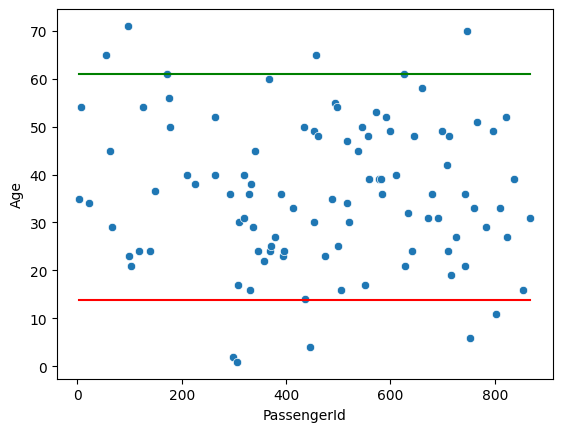

In [28]:
pl = np.percentile(perc['Age'], 5)
pu = np.percentile(perc['Age'], 95)
sns.scatterplot(x = perc['PassengerId'], y = perc['Age'])
sns.lineplot(x = perc['PassengerId'], y = pl, color = 'red')
sns.lineplot(x = perc['PassengerId'], y = pu, color = 'green')

In [29]:
procesador = perc[(perc['Age']>=pl) & (perc['Age']<=pu)]
procesador[['Age']].describe()

,Age
count,91.000000
mean,36.456044
std,12.305520
min,14.000000
25%,26.000000
50%,36.000000
75%,48.000000
max,61.000000


In [30]:
perc['Age_drop'] = procesador['Age']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\2532910126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Age_drop'] = procesador['Age']


In [31]:
perc['Age_pcv'] = np.where(
    perc['Age']<pl,
    pl,
    np.where(
        perc['Age']>pu,
        pu,
        perc['Age']
    )
)

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\3258818347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Age_pcv'] = np.where(


In [32]:
perc[['Age', 'Age_pcv', 'Age_drop']].describe()

,Age,Age_pcv,Age_drop
count,100.000000,100.000000,91.000000
mean,36.124200,36.307500,36.456044
std,15.123837,13.703537,12.305520
min,0.920000,13.850000,14.000000
25%,24.000000,24.000000,26.000000
50%,36.000000,36.000000,36.000000
75%,48.250000,48.250000,48.000000
max,71.000000,61.000000,61.000000


###### SibSp

<AxesSubplot: xlabel='PassengerId', ylabel='SibSp'>

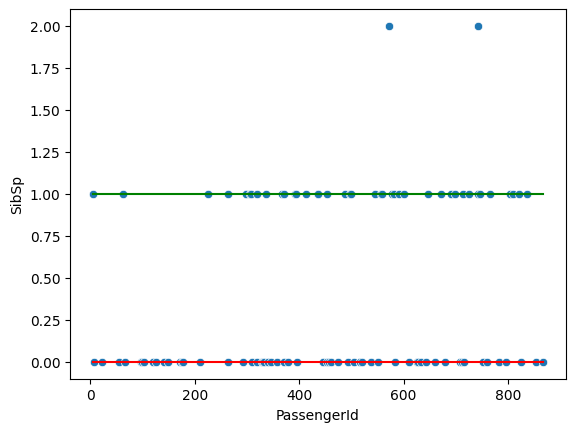

In [33]:
pl = np.percentile(perc['SibSp'], 5)
pu = np.percentile(perc['SibSp'], 95)
sns.scatterplot(x = perc['PassengerId'], y = perc['SibSp'])
sns.lineplot(x = perc['PassengerId'], y = pl, color = 'red')
sns.lineplot(x = perc['PassengerId'], y = pu, color = 'green')

No vale la pena trabajarlo por solo dos datos

##### Parch

<AxesSubplot: xlabel='PassengerId', ylabel='Parch'>

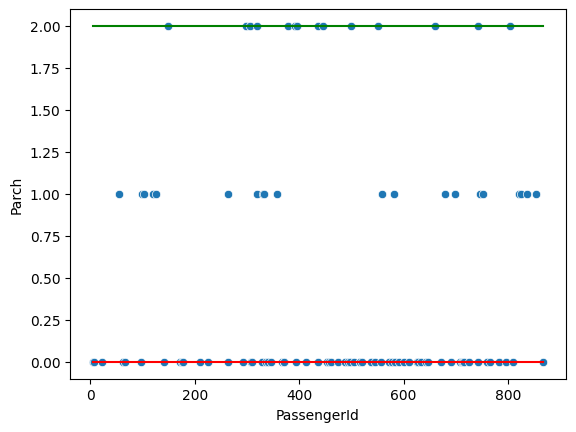

In [34]:
pl = np.percentile(perc['Parch'], 5)
pu = np.percentile(perc['Parch'], 95)
sns.scatterplot(x = perc['PassengerId'], y = perc['Parch'])
sns.lineplot(x = perc['PassengerId'], y = pl, color = 'red')
sns.lineplot(x = perc['PassengerId'], y = pu, color = 'green')

In [35]:
procesador = perc[(perc['Parch']>=pl) & (perc['Parch']<=pu)]
procesador[['Parch']].describe()

,Parch
count,100.000000
mean,0.480000
std,0.731402
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [36]:
perc['Parch_drop'] = procesador['Parch']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\1498318944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Parch_drop'] = procesador['Parch']


In [37]:
perc['Parch_pcv'] = np.where(
    perc['Parch']<pl,
    pl,
    np.where(
        perc['Parch']>pu,
        pu,
        perc['Parch']
    )
)

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\3502846943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Parch_pcv'] = np.where(


In [38]:
perc[['Parch', 'Parch_pcv', 'Parch_drop']].describe()

,Parch,Parch_pcv,Parch_drop
count,100.000000,100.000000,100.000000
mean,0.480000,0.480000,0.480000
std,0.731402,0.731402,0.731402
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000


###### Fare

<AxesSubplot: xlabel='PassengerId', ylabel='Fare'>

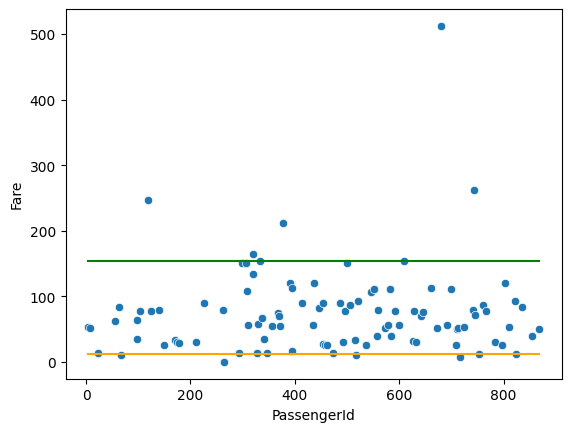

In [39]:
pl = np.percentile(perc['Fare'], 5)
pu = np.percentile(perc['Fare'], 95)
sns.scatterplot(x = perc['PassengerId'], y = perc['Fare'])
sns.lineplot(x = perc['PassengerId'], y = pl, color = 'orange')
sns.lineplot(x = perc['PassengerId'], y = pu, color = 'green')

In [40]:
procesador = perc[(perc['Fare']>=pl) & (perc['Fare']<=pu)]
procesador[['Fare']].describe()

,Fare
count,91.000000
mean,66.123856
std,36.887605
min,12.475000
25%,33.760400
50%,57.979200
75%,86.500000
max,153.462500


In [41]:
perc['Fare_drop'] = procesador['Fare']

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\1096062592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Fare_drop'] = procesador['Fare']


In [42]:
perc['Fare_pcv'] = np.where(
    perc['Fare']<pl,
    pl,
    np.where(
        perc['Fare']>pu,
        pu,
        perc['Fare']
    )
)

C:\Users\danie\AppData\Local\Temp\ipykernel_20764\2994611872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc['Fare_pcv'] = np.where(


In [43]:
perc[['Fare', 'Fare_pcv', 'Fare_drop']].describe()

,Fare,Fare_pcv,Fare_drop
count,100.000000,100.000000,91.000000
mean,74.445126,68.373344,66.123856
std,65.975260,41.695044,36.887605
min,0.000000,12.475000,12.475000
25%,31.990600,31.990600,33.760400
50%,59.979200,59.979200,57.979200
75%,90.000000,90.000000,86.500000
max,512.329200,154.032710,153.462500


In [44]:
perc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_drop,Age_pcv,Parch_drop,Parch_pcv,Fare_drop,Fare_pcv
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,35.0,35.0,0.0,0.0,53.1000,53.1000
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,E46,S,54.0,54.0,0.0,0.0,51.8625,51.8625
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,D56,S,34.0,34.0,0.0,0.0,13.0000,13.0000
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,B30,C,NaN,61.0,1.0,1.0,61.9792,61.9792
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,C83,S,45.0,45.0,0.0,0.0,83.4750,83.4750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1.0,1.0,12749,93.5000,B69,S,52.0,52.0,1.0,1.0,93.5000,93.5000
172,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0.0,1.0,392096,12.4750,E121,S,27.0,27.0,1.0,1.0,12.4750,12.4750
173,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1.0,1.0,PC 17756,83.1583,E49,C,39.0,39.0,1.0,1.0,83.1583,83.1583
174,854,1,1,"Lines, Miss. Mary Conover",female,16.0,0.0,1.0,PC 17592,39.4000,D28,S,16.0,16.0,1.0,1.0,39.4000,39.4000


## 5. Comparaciones de Eficiencia

NOTA: Los primeros 4, incluido el modelo lineal, tienen la cantidad total, pero los percentiles no tienen la información 
completa. Aunque Lm necesita de todos lo datos, he incluido la predicción en los datos NAs de edad, pero los percentiles 
solo puedo forzar los conocidos ya que los NAs no se si están arriba o abajo, por lo que es más un proceso de normalización.

#### Age

In [45]:
titanicG[['Age']].describe()

,Age
count,183.000000
mean,35.674426
std,15.643866
min,0.920000
25%,24.000000
50%,36.000000
75%,47.500000
max,80.000000


In [46]:
comparativa[['Age_mean', 'Age_mode', 'Age_median', 'Age_lm']].describe()

,Age_mean,Age_mode,Age_median,Age_lm
count,183.000000,183.000000,183.00000,183.000000
mean,35.692186,34.095191,35.66623,35.751503
std,14.526959,15.074700,14.52711,14.527719
min,0.920000,0.920000,0.92000,0.920000
25%,25.000000,24.000000,25.00000,25.000000
50%,35.690000,31.000000,35.50000,36.124200
75%,46.500000,46.500000,46.50000,46.500000
max,80.000000,80.000000,80.00000,80.000000


In [47]:
perc[['Age_drop', 'Age_pcv']].describe()

,Age_drop,Age_pcv
count,91.000000,100.000000
mean,36.456044,36.307500
std,12.305520,13.703537
min,14.000000,13.850000
25%,26.000000,24.000000
50%,36.000000,36.000000
75%,48.000000,48.250000
max,61.000000,61.000000


* Mean: el proceso de media y mediana fueron los que más se acercaron, pero la mediana falló por 0.008. El modelo predijo bastante bien pero se quedó aun un poco lejos. Los percentiles fueron los peores predictores.

* Std: el proceso de la moda fue el que se acercó más a la desviación, aunque se quedó corta por 0.58. La media, mediana y el modelo tienen valores muy similares y nuevamente los percentiles se quedaron atrás.

* Min y Max: la media, mediana, moda y predicción devolvieron los valores correctos, intuyo que es porque ya existian, mientras que los percentiles fallaron por mucho. Al 25% solamente la moda y el PCV acertaron, aunque los demás estaban en 25, lo que es aceptable. Al 50%, los percentiles acertaron exacto, la predicción fue la que más se acercó de las otras (por 0.12) y la media de acercó por 0.32, siendo la tercera más acertada. Al 75% ningún método acertó, el más cercano fue drop con 0.50 de diferencia y los demás se quedaron a 1 de diferencia.

En el caso de la edad, la media fue el método más acertado para predecir la edad de las personas a las que les faltaba esta información, ya que fue la más constante al acercarse al dato exacto.

#### SibSp

In [48]:
titanicG[['SibSp']].describe()

,SibSp
count,183.000000
mean,0.464481
std,0.644159
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3.000000


In [49]:
comparativa[['SibSp_mean', 'SibSp_mode', 'SibSp_median', 'SibSp_lm']].describe()

,SibSp_mean,SibSp_mode,SibSp_median,SibSp_lm
count,183.000000,183.000000,183.000000,183.000000
mean,0.453552,0.453552,0.453552,0.453552
std,0.643459,0.643459,0.643459,0.643459
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,3.000000,3.000000,3.000000,3.000000


**NO SE TRABAJÓ PARA ESTA EL METODO DEL PERCENTIL**

Dado a que esta columna solo tenía 3 valores faltantes, las imputaciones son idénticas y los márgenes de error son casi 0, ya que imputaron casi igual todos los 3 datoa faltantes. Creo que no hay suficientes datos faltantes para indicar cuál de los modelos es el ideal para imputar en esta columna.

#### Parch

In [50]:
titanicG[['Parch']].describe()

,Parch
count,183.000000
mean,0.475410
std,0.754617
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [51]:
comparativa[['Parch_mean', 'Parch_mode', 'Parch_median', 'Parch_lm']].describe()

,Parch_mean,Parch_mode,Parch_median,Parch_lm
count,183.000000,183.000000,183.000000,183.000000
mean,0.431694,0.431694,0.431694,0.431694
std,0.737147,0.737147,0.737147,0.737147
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000


In [52]:
perc[['Parch_drop', 'Parch_pcv']].describe()

,Parch_drop,Parch_pcv
count,100.000000,100.000000
mean,0.480000,0.480000
std,0.731402,0.731402
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,2.000000,2.000000


* Mean: Drop y PCV fallaron por 0.004 mientras que la media, moda, mediana y el promedio fallaron por 0.04, una gran diferencia entre los modelos.

* Std: la desvación estándar fue la misma para todos y se quedó a 0.02 de la desviación correcta.

* Min y Max: la media, mediana, moda y predicción devolvieron los valores correctos en todos los porcentajes de los cuartiles, mientras que los percentiles en el max retornaron 2, que no es el valor correcto; esto se debió principalmente porque al forzar bajar esos resultados, el max estará sobre el cuartil al 95% y en los otros se mantiene el pico borrado acá.

En este caso, aunque los 4 primeros métodos fallaron por 0.04, la diferencia no es tan avismal entre el fallo. Mientras que los percentiles fueron más exactos en muchas cosas, pero "pre normalizaron la información" y por eso el máximo es diferente. Creo que en este caso, la forma usando percentiles no es una mala alternativa, aunque con más datos faltantes podríamos ver un comportmiento diferente y anormal, donde quizas otro método sea el más recomendado.

#### Fare

In [53]:
titanicG[['Fare']].describe()

,Fare
count,183.000000
mean,78.682469
std,76.347843
min,0.000000
25%,29.700000
50%,57.000000
75%,90.000000
max,512.329200


In [54]:
comparativa[['Fare_mean', 'Fare_mode', 'Fare_median', 'Fare_lm']].describe()

,Fare_mean,Fare_mode,Fare_median,Fare_lm
count,183.000000,183.000000,183.000000,183.000000
mean,78.959399,76.668079,77.996131,78.761855
std,75.314437,76.077057,75.449730,75.320104
min,0.000000,0.000000,0.000000,0.000000
25%,30.000000,26.550000,30.000000,30.000000
50%,61.180000,55.441700,56.929200,61.175000
75%,90.000000,90.000000,90.000000,90.000000
max,512.330000,512.329200,512.329200,512.329200


In [55]:
perc[['Fare_drop', 'Fare_pcv']].describe()

,Fare_drop,Fare_pcv
count,91.000000,100.000000
mean,66.123856,68.373344
std,36.887605,41.695044
min,12.475000,12.475000
25%,33.760400,31.990600
50%,57.979200,59.979200
75%,86.500000,90.000000
max,153.462500,154.032710


* Mean: La predicción y la media fueron los métodos más acertados, con una diferencia de 0.08 y 0.27 respectivamente. La moda y la mediana se acercán más, pero la diferencia es mayor (1 < dif < 2). Los cuartiles se queraron muy lejos de los valores reales.

* Std: La moda fue la que más se acercó al valor real, con una diferencia de 0.27, seguida de cerca por la mediana, la predicción y la media, respectivamente. Los cuartiles dejan mucho que desear.

* Min y Max: los primeros 4 procesos acertaron el mínimo y el máximo (contrario a los cuartiles). En el 25% la media, mediana y el modelo fallaron por 0.3 y la moda se quedó más atrás junto a los percentiles, solo que esta vez estuvieron mucho más cerca. En el 50% la mediana falló por 0.07, siendo esta la más precisa; le siguen muy de cerca los cuartiles en drop y la moda. Pcv, la media y el modelo tienen un márgen más amplio.

Dado que en este caso el precio es muy variado, el modelo es el ideal para poder realizar las imputaciones respectivas, aunque la mediana, al no ser tan volatil con su precisión como los otros métodos en general, puede ser otra opción no tan pesada como hacer un modelo predictivo para hacer estas imputaciones.

#### Sex

In [56]:
titanicG[['Sex']].describe()

,Sex
count,183
unique,2
top,male
freq,95


In [57]:
comparativa[['Sex_mode']].describe()

,Sex_mode
count,183
unique,2
top,male
freq,119


* ORIGINAL: 95-88 (51% - 49%)
* POR MODA: 119-64 (65% - 35%)

Ya que esta variable es de tipo STRING y es parecida a una BOOLEANA, la moda es el único método que se puede aplicar para realizar las imputaciones. En este caso, tiene una variación del 13% respecto los datos iniciales. Podemos ver que pasamos de afirmar que hay casi la misma cantidad de hombres que de mujeres a afirmar que casi 2/3 de los datos son hombres y la diferencia de mujeres, implicando que si hay un sesgo muy marcado por parte de la moda. Esta era la columna con más datos faltantes, lo que explica por qué hubo un sesgo muy marcado.

#### Embarked

In [58]:
titanicG[['Embarked']].value_counts()

Embarked
S           116
C            65
Q             2
dtype: int64

In [59]:
comparativa[['Embarked_mode']].value_counts()

Embarked_mode
S                122
C                 59
Q                  2
dtype: int64

* ORIGINAL: 116-65-2 (63% - 36% - 1%)
* POR MODA: 122-59-2 (66% - 33% - 1%)

Ya que esta variable es de tipo STRING y es parecida a una BOOLEANA, la moda es el único método que se puede aplicar para realizar las imputaciones. En este caso, tiene una variación del 3% respecto los datos iniciales, lo cual no es tan significativo en cambio y no sesga mucho la columna.

## 6. Conclusiones

Derivado de las evaluaciones previas, puedo concluir lo siguiente:

- Hay un riesgo muy alto de sesgar la data usando la moda. Si la información que falta es mucha, se puede sesgar toda una columna y, por lo tanto, sesgar equivocadamente un modelo a predecir. Si hay pocos datos faltantes que no pueden imputarse de otra forma, puede usarse la moda; si faltan muchos datos y la moda es la única alternativa, lo mejor es hacer una eliminación ya que el riesgo de un sesgo artificial es muy alto.

- Las medias y medianas son buenas formas de imputar la data fácil y rápido dependiendo de la variabilidad de los datos y de la distribución que poseen. Una buena forma puede ser primero identificar la distribución que posee la información para determinar cuál de las dos es la más adecuada o si se requiere otra forma para realizar las imputaciones.

- Si hace falta mucha información, un modelo de regresión no es lo más adecuado ya que no tiene suficiente para entrenarse y predecir adecuadamente, aunque con pocos datos faltantes es una buena alternativa si se cuenta con tiempo para entrenar un modelo y hacer las imputaciones.

- Los outliders son buenos cuando la data está casi completa, porque pueden fallar dependiendo de cuánto falta en el Dataset, pero si son buenos para normalizar.

## 7. Normalización

#### Standarization

In [60]:
scaler = StandardScaler()
tratada_z = comparativa.copy()
for col in tratada_z.select_dtypes(include=['float', 'int']).columns:
    tratada_z[col+'_z'] = scaler.fit_transform(tratada_z[[col]])
tratada_z.head()

,Sex_mode,Age_mean,Age_median,Age_mode,SibSp_mean,SibSp_median,SibSp_mode,Parch_mean,Parch_median,Parch_mode,...,Parch_mean_z,Parch_median_z,Parch_mode_z,Fare_mean_z,Fare_median_z,Fare_mode_z,Age_lm_z,SibSp_lm_z,Parch_lm_z,Fare_lm_z
0,male,38.00,38.0,38.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.587235,-0.587235,-0.587235,-0.102244,-0.089215,-0.070975,0.155198,0.851565,-0.587235,-0.099563
1,female,35.00,35.0,35.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.587235,-0.587235,-0.587235,-0.344294,-0.330875,-0.310642,-0.051871,0.851565,-0.587235,-0.341639
2,male,54.00,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.587235,-0.587235,-0.587235,-0.360804,-0.347322,-0.326953,1.259562,-0.706799,-0.587235,-0.358114
3,female,35.69,35.5,24.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.587235,-0.587235,-0.587235,-0.828927,-0.814639,-0.790417,0.025725,0.851565,-0.587235,-0.826235
4,female,58.00,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.587235,-0.587235,-0.587235,-0.697784,-0.683730,-0.660588,1.535653,-0.706799,-0.587235,-0.695101


In [61]:
tratada_z2 = perc.copy()
for col in tratada_z2.select_dtypes(include=['float', 'int']).columns:
    tratada_z2[col+'_z'] = scaler.fit_transform(tratada_z2[[col]])
tratada_z2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_z,SibSp_z,Parch_z,Fare_z,Age_drop_z,Age_pcv_z,Parch_drop_z,Parch_pcv_z,Fare_drop_z,Fare_pcv_z
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,-0.074707,1.046409,-0.659580,-0.325162,-0.118980,-0.095894,-0.659580,-0.659580,-0.355025,-0.368156
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,...,1.187916,-0.822179,-0.659580,-0.344014,1.433597,1.297594,-0.659580,-0.659580,-0.388758,-0.397985
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,...,-0.141161,-0.822179,-0.659580,-0.936028,-0.200695,-0.169235,-0.659580,-0.659580,-1.448133,-1.334746
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,...,1.918909,-0.822179,0.714545,-0.189900,NaN,1.810985,0.714545,0.714545,-0.112982,-0.154128
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,...,0.589831,1.046409,-0.659580,0.137557,0.698166,0.637521,-0.659580,-0.659580,0.472985,0.364018


In [62]:
titanic_z = titanicG.copy()
for col in titanic_z.select_dtypes(include=['float', 'int']).columns:
    titanic_z[col+'_z'] = scaler.fit_transform(titanic_z[[col]])
titanic_z.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId_z,Survived_z,Pclass_z,Age_z,SibSp_z,Parch_z,Fare_z
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,-1.840135,0.698430,-0.372256,0.149065,0.833628,-0.631730,-0.097180
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,-1.832017,0.698430,-0.372256,-0.043230,0.833628,-0.631730,-0.335997
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,-1.819841,-1.431782,-0.372256,1.174636,-0.723044,-0.631730,-0.352250
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,-1.803606,0.698430,3.520480,-2.030273,0.833628,0.697081,-0.814070
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,-1.799547,0.698430,-0.372256,1.431029,-0.723044,-0.631730,-0.684702


#### Min Max Scaling

In [63]:
scaler = MinMaxScaler()
tratada_mm = comparativa.copy()
for col in tratada_mm.select_dtypes(include=['float', 'int']).columns:
    tratada_mm[col+'_norm'] = scaler.fit_transform(tratada_mm[[col]])
tratada_mm.head()

,Sex_mode,Age_mean,Age_median,Age_mode,SibSp_mean,SibSp_median,SibSp_mode,Parch_mean,Parch_median,Parch_mode,...,Parch_mean_norm,Parch_median_norm,Parch_mode_norm,Fare_mean_norm,Fare_median_norm,Fare_mode_norm,Age_lm_norm,SibSp_lm_norm,Parch_lm_norm,Fare_lm_norm
0,male,38.00,38.0,38.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.139129,0.139136,0.139136,0.468892,0.333333,0.0,0.139136
1,female,35.00,35.0,35.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.103644,0.103644,0.103644,0.430956,0.333333,0.0,0.103644
2,male,54.00,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.101224,0.101229,0.101229,0.671219,0.000000,0.0,0.101229
3,female,35.69,35.5,24.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032596,0.032596,0.032596,0.445172,0.333333,0.0,0.032596
4,female,58.00,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.051822,0.051822,0.051822,0.721801,0.000000,0.0,0.051822


In [64]:
tratada_mm2 = perc.copy()
for col in tratada_mm2.select_dtypes(include=['float', 'int']).columns:
    tratada_mm2[col+'_norm'] = scaler.fit_transform(tratada_mm2[[col]])
tratada_mm2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_norm,SibSp_norm,Parch_norm,Fare_norm,Age_drop_norm,Age_pcv_norm,Parch_drop_norm,Parch_pcv_norm,Fare_drop_norm,Fare_pcv_norm
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,0.486301,0.5,0.0,0.103644,0.446809,0.448568,0.0,0.0,0.288146,0.286985
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,...,0.757420,0.0,0.0,0.101229,0.851064,0.851538,0.0,0.0,0.279369,0.278243
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,...,0.472032,0.0,0.0,0.025374,0.425532,0.427359,0.0,0.0,0.003724,0.003709
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,...,0.914384,0.0,0.5,0.120975,NaN,1.000000,0.5,0.5,0.351125,0.349710
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,...,0.628995,0.5,0.0,0.162932,0.659574,0.660657,0.0,0.0,0.503591,0.501562


In [65]:
titanic_mm = titanicG.copy()
for col in titanic_mm.select_dtypes(include=['float', 'int']).columns:
    titanic_mm[col+'_norm'] = scaler.fit_transform(titanic_mm[[col]])
titanic_mm.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId_norm,Survived_norm,Pclass_norm,Age_norm,SibSp_norm,Parch_norm,Fare_norm
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.000000,1.0,0.0,0.468892,0.333333,0.00,0.139136
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.002252,1.0,0.0,0.430956,0.333333,0.00,0.103644
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.005631,0.0,0.0,0.671219,0.000000,0.00,0.101229
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,0.010135,1.0,1.0,0.038948,0.333333,0.25,0.032596
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0.011261,1.0,0.0,0.721801,0.000000,0.00,0.051822


#### MaxAbs Scaler

In [66]:
scaler = MaxAbsScaler()
tratada_ma = comparativa.copy()
for col in tratada_ma.select_dtypes(include=['float', 'int']).columns:
    tratada_ma[col+'_MabsS'] = scaler.fit_transform(tratada_ma[[col]])
tratada_ma.head()

,Sex_mode,Age_mean,Age_median,Age_mode,SibSp_mean,SibSp_median,SibSp_mode,Parch_mean,Parch_median,Parch_mode,...,Parch_mean_MabsS,Parch_median_MabsS,Parch_mode_MabsS,Fare_mean_MabsS,Fare_median_MabsS,Fare_mode_MabsS,Age_lm_MabsS,SibSp_lm_MabsS,Parch_lm_MabsS,Fare_lm_MabsS
0,male,38.00,38.0,38.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.139129,0.139136,0.139136,0.475000,0.333333,0.0,0.139136
1,female,35.00,35.0,35.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.103644,0.103644,0.103644,0.437500,0.333333,0.0,0.103644
2,male,54.00,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.101224,0.101229,0.101229,0.675000,0.000000,0.0,0.101229
3,female,35.69,35.5,24.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032596,0.032596,0.032596,0.451553,0.333333,0.0,0.032596
4,female,58.00,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.051822,0.051822,0.051822,0.725000,0.000000,0.0,0.051822


In [67]:
tratada_ma2 = perc.copy()
for col in tratada_ma2.select_dtypes(include=['float', 'int']).columns:
    tratada_ma2[col+'_MabsS'] = scaler.fit_transform(tratada_ma2[[col]])
tratada_ma2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_MabsS,SibSp_MabsS,Parch_MabsS,Fare_MabsS,Age_drop_MabsS,Age_pcv_MabsS,Parch_drop_MabsS,Parch_pcv_MabsS,Fare_drop_MabsS,Fare_pcv_MabsS
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,...,0.492958,0.5,0.0,0.103644,0.573770,0.573770,0.0,0.0,0.346013,0.344732
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.8625,...,0.760563,0.0,0.0,0.101229,0.885246,0.885246,0.0,0.0,0.337949,0.336698
5,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0.0,0.0,248698,13.0000,...,0.478873,0.0,0.0,0.025374,0.557377,0.557377,0.0,0.0,0.084711,0.084398
9,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0.0,1.0,113509,61.9792,...,0.915493,0.0,0.5,0.120975,NaN,1.000000,0.5,0.5,0.403872,0.402377
10,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1.0,0.0,36973,83.4750,...,0.633803,0.5,0.0,0.162932,0.737705,0.737705,0.0,0.0,0.543944,0.541930


In [68]:
titanic_ma = titanicG.copy()
for col in titanic_ma.select_dtypes(include=['float', 'int']).columns:
    titanic_ma[col+'_MabsS'] = scaler.fit_transform(titanic_ma[[col]])
titanic_ma.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId_MabsS,Survived_MabsS,Pclass_MabsS,Age_MabsS,SibSp_MabsS,Parch_MabsS,Fare_MabsS
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.002247,1.0,0.333333,0.4750,0.333333,0.00,0.139136
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.004494,1.0,0.333333,0.4375,0.333333,0.00,0.103644
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.007865,0.0,0.333333,0.6750,0.000000,0.00,0.101229
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,0.012360,1.0,1.000000,0.0500,0.333333,0.25,0.032596
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0.013483,1.0,0.333333,0.7250,0.000000,0.00,0.051822


## 8. Comparación y Conclusiones

#### Age

In [76]:
Age_Norm = pd.DataFrame()

Age_Norm['Age_z'] = titanic_z['Age_z']
Age_Norm['Age_mean_z'] = tratada_z['Age_mean_z']
Age_Norm['Age_mode_z'] = tratada_z['Age_mode_z']
Age_Norm['Age_median_z'] = tratada_z['Age_median_z']
Age_Norm['Age_lm_z'] = tratada_z['Age_lm_z']
Age_Norm['Age_pcv_z'] = tratada_z2['Age_pcv_z']
Age_Norm['Age_drop_z'] = tratada_z2['Age_drop_z']

Age_Norm['Age_norm'] = titanic_mm['Age_norm']
Age_Norm['Age_mean_norm'] = tratada_mm['Age_mean_norm']
Age_Norm['Age_mode_norm'] = tratada_mm['Age_mode_norm']
Age_Norm['Age_median_norm'] = tratada_mm['Age_median_norm']
Age_Norm['Age_lm_norm'] = tratada_mm['Age_lm_norm']
Age_Norm['Age_pcv_norm'] = tratada_mm2['Age_pcv_norm']
Age_Norm['Age_drop_norm'] = tratada_mm2['Age_drop_norm']

Age_Norm['Age_MabsS'] = titanic_ma['Age_MabsS']
Age_Norm['Age_mean_MabsS'] = tratada_ma['Age_mean_MabsS']
Age_Norm['Age_mode_MabsS'] = tratada_ma['Age_mode_MabsS']
Age_Norm['Age_median_MabsS'] = tratada_ma['Age_median_MabsS']
Age_Norm['Age_lm_MabsS'] = tratada_ma['Age_lm_MabsS']
Age_Norm['Age_pcv_MabsS'] = tratada_ma2['Age_pcv_MabsS']
Age_Norm['Age_drop_MabsS'] = tratada_ma2['Age_drop_MabsS']

In [77]:
Age_Norm[['Age_z', 'Age_mean_z', 'Age_mode_z', 'Age_median_z', 'Age_lm_z', 'Age_pcv_z', 'Age_drop_z']].describe()

,Age_z,Age_mean_z,Age_mode_z,Age_median_z,Age_lm_z,Age_pcv_z,Age_drop_z
count,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.000000e+02,91.000000
mean,-1.650168e-16,5.338777e-17,-1.019221e-16,-9.706868e-18,3.640075e-16,2.131628e-16,0.000000
std,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.005038e+00,1.005540
min,-2.227696e+00,-2.400198e+00,-2.206757e+00,-2.398382e+00,-2.404167e+00,-1.647066e+00,-1.834986
25%,-7.483096e-01,-7.380430e-01,-6.715150e-01,-7.362436e-01,-7.420986e-01,-9.026504e-01,-0.854411
50%,2.086869e-02,-1.508774e-04,-2.058869e-01,-1.147410e-02,2.572460e-02,-2.255251e-02,-0.037265
75%,7.579979e-01,7.460244e-01,8.251468e-01,7.478083e-01,7.418911e-01,8.758807e-01,0.943309
max,2.841189e+00,3.058408e+00,3.053510e+00,3.060168e+00,3.054154e+00,1.810985e+00,2.005599


In [78]:
Age_Norm[['Age_norm', 'Age_mean_norm', 'Age_mode_norm', 'Age_median_norm', 'Age_lm_norm', 'Age_pcv_norm', 'Age_drop_norm']].describe()

,Age_norm,Age_mean_norm,Age_mode_norm,Age_median_norm,Age_lm_norm,Age_pcv_norm,Age_drop_norm
count,183.000000,183.000000,183.000000,183.000000,183.000000,100.000000,91.000000
mean,0.439484,0.439709,0.419514,0.439381,0.440459,0.476299,0.477788
std,0.197823,0.183700,0.190626,0.183701,0.183709,0.290637,0.261820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.291856,0.304502,0.291856,0.304502,0.304502,0.215270,0.255319
50%,0.443601,0.439681,0.380374,0.437279,0.445172,0.469777,0.468085
75%,0.589024,0.576378,0.576378,0.576378,0.576378,0.729586,0.723404
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
Age_Norm[['Age_MabsS', 'Age_mean_MabsS', 'Age_mode_MabsS', 'Age_median_MabsS', 'Age_lm_MabsS', 'Age_pcv_MabsS', 'Age_drop_MabsS']].describe()

,Age_MabsS,Age_mean_MabsS,Age_mode_MabsS,Age_median_MabsS,Age_lm_MabsS,Age_pcv_MabsS,Age_drop_MabsS
count,183.000000,183.000000,183.000000,183.000000,183.000000,100.000000,91.000000
mean,0.445930,0.446152,0.426190,0.445828,0.446894,0.595205,0.597640
std,0.195548,0.181587,0.188434,0.181589,0.181596,0.224648,0.201730
min,0.011500,0.011500,0.011500,0.011500,0.011500,0.227049,0.229508
25%,0.300000,0.312500,0.300000,0.312500,0.312500,0.393443,0.426230
50%,0.450000,0.446125,0.387500,0.443750,0.451553,0.590164,0.590164
75%,0.593750,0.581250,0.581250,0.581250,0.581250,0.790984,0.786885
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Mean: normalizar la edad usando Standarization es más exacto, ya que todos se encuentran muy cerca de su media sin variar demasiado (tomando en cuenta que es casi 0). En los otros dos casos, la moda no se acercó tanto a lo normal y los resultados de los outliers quedaron lejos de la realidad.

* Std: En los tres métodos los resulados de los Outliers están muy alejados de la realidad (excepto en el Drop con MaxAbs). Standarization mantiene la misma desviación para la media, moda, mediana y el modelo y 

* Min y Max: los primeros 4 procesos acertaron el mínimo y el máximo (contrario a los cuartiles). En el 25% la media, mediana y el modelo fallaron por 0.3 y la moda se quedó más atrás junto a los percentiles, solo que esta vez estuvieron mucho más cerca. En el 50% la mediana falló por 0.07, siendo esta la más precisa; le siguen muy de cerca los cuartiles en drop y la moda. Pcv, la media y el modelo tienen un márgen más amplio.